In [111]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
from scipy import stats
import pandas as pd
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [61]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

ImportError: cannot import name 'TypeGuard' from 'typing_extensions' (/root/anaconda3/lib/python3.7/site-packages/typing_extensions.py)

In [112]:
def cal_kge(y_true, y_pred):
    r = pearsonr(y_true, y_pred)[0]
    beta = np.mean(y_pred)/np.mean(y_true)
    gamma = (np.std(y_pred)/np.mean(y_pred)) / \
        (np.std(y_true)/np.mean(y_true))
    return 1-np.sqrt((r-1)**2+(beta-1)**2+(gamma-1)**2),  beta, gamma

def cal_mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

def cal_autocorr(x, t=1):
    return np.corrcoef(np.array(x[0:len(x) - t]), np.array(x[t:len(x)]))

def SWDIcount(SM):
    SM_95=np.nanpercentile(SM, 95)
    SM_05 = np.nanpercentile(SM, 5)
    SWDI=(SM-SM_95)/(SM_95-SM_05)*10
    return SWDI

def SWDIlevel(SWDIs):
    SWDILevelList=[]
    for SWDI in SWDIs:
        if SWDI > 0:
            level="No drought"
        if SWDI < 0 and SWDI >-2:
            level="Mild"
        if SWDI < -2 and SWDI >-5:
            level="Moderate"
        if SWDI < -5 and SWDI >-10:
            level="Severe"
        if SWDI < -10 :
            level="Extreme"
        SWDILevelList.append(level)
    return SWDILevelList

In [113]:
path_output = '/hard/lilu/2_CausalLSTM/clstmcases/7DD_threshold-0.5/output/'
path_loss = '/hard/lilu/2_CausalLSTM/clstmcases/7DD_threshold-0.5/loss/'
path_info = '/hard/lilu/2_CausalLSTM/clstmcases/7DD_threshold-0.5/info/'

l = glob.glob(path_output + '*' + '_out.npy', recursive=True)
N_sites = len(l)

# init
r = np.full((N_sites,3), np.nan)
nse = np.full((N_sites,3), np.nan)
rmse = np.full((N_sites,3), np.nan)
nrmse = np.full((N_sites,3), np.nan)
mape = np.full((N_sites,3), np.nan)
kge = np.full((N_sites,3), np.nan)
bias = np.full((N_sites,3), np.nan)
beta = np.full((N_sites,3), np.nan)
gamma = np.full((N_sites,3), np.nan)
ttest = np.full((N_sites,2), 0)
length = np.full((N_sites,), np.nan)
tac = np.full((N_sites,), np.nan)

site_name_list = []

for i,name_ in enumerate(l):
    
    name = name_.split('/')[-1]
    site_name = name.split('_')[0]
    site_name_list.append(site_name)
    
    output = np.load(name_)
    length[i] = output.shape[0]
    
    # cal metrics
    r[i,0] = pearsonr(output[:,-1], output[:,0])[0]
    r[i,1] = pearsonr(output[:,-1], output[:,1])[0]
    r[i, 2] = pearsonr(output[:, -1], output[:, 2])[0]
    
    kge[i,0],beta[i,0], gamma[i,0]  = cal_kge(output[:,-1], output[:,0])
    kge[i,1],beta[i,1], gamma[i,1] = cal_kge(output[:,-1], output[:,1])
    kge[i, 2],beta[i,2], gamma[i,2] = cal_kge(output[:, -1], output[:, 2])    
    
    nse[i,0] = r2_score(output[:,-1], output[:,0])
    nse[i,1] = r2_score(output[:,-1], output[:,1])
    nse[i, 2] = r2_score(output[:, -1], output[:, 2])
    
    rmse[i,0] = np.sqrt(mean_squared_error(output[:,-1], output[:,0]))
    rmse[i,1] = np.sqrt(mean_squared_error(output[:,-1], output[:,1]))
    rmse[i, 2] = np.sqrt(mean_squared_error(output[:, -1], output[:, 2]))

    
    nrmse[i,0] = np.sqrt(mean_squared_error(output[:,-1], output[:,0]))/np.nanmean(output[:,-1])
    nrmse[i,1] = np.sqrt(mean_squared_error(output[:,-1], output[:,1]))/np.nanmean(output[:,-1])
    nrmse[i, 2] = np.sqrt(mean_squared_error(output[:, -1], output[:, 2]))/np.nanmean(output[:,-1])
    
    mape[i,0] = cal_mape(output[:,-1], output[:,0])
    mape[i,1] = cal_mape(output[:,-1], output[:,1])  
    mape[i, 2] = cal_mape(output[:, -1], output[:, 2])
    
    bias[i,0] = np.mean(output[:, -1])-np.mean(output[:, 0])
    bias[i,1] = np.mean(output[:, -1])-np.mean(output[:, 1])
    bias[i, 2] = np.mean(output[:, -1])-np.mean(output[:, 2])

    tac[i] = cal_autocorr(output[:, -1], t=7)[0, 1]

    t, p = stats.ttest_ind(np.abs(output[:,2]-output[:,-1]), np.abs(output[:,-1]-output[:,1]),alternative='less')
    if p<0.05:
        ttest[i,0] = 1
    
    t, p = stats.ttest_ind(np.abs(output[:,2]-output[:,-1]), np.abs(output[:,-1]-output[:,1]),alternative='greater')
    if p<0.05:
        ttest[i,1] = 1

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


In [114]:
# init
history = np.full((N_sites, 50, 4), np.nan)

# process
for i, site_name in enumerate(site_name_list):
    output = np.load(path_loss + site_name + '_loss.npy')
    history[i, :, 0] = output[0:50]
    history[i,:,1] = output[50:100]
    history[i,:,2] = output[100:150]
    history[i,:,3] = output[150:200]

In [115]:
df = pd.read_csv('/hard/lilu/FLX2015_DD/site_summary.csv')
lat = df['latitude'].values
lon = df['longitude'].values

# Figure 3

In [116]:
relative_improve_nse = np.full((N_sites,), np.nan)
relative_improve_mape = np.full((N_sites,), np.nan)
relative_improve_kge = np.full((N_sites,), np.nan)
relative_improve_rmse = np.full((N_sites,), np.nan)


for i in range(N_sites):
    if kge[i,1] < 0 and kge[i,2] > 0:
        relative_improve_kge[i] = 100*(kge[i,2]-kge[i,1])/np.abs(kge[i,1])
    else:
        relative_improve_kge[i] = 100*(kge[i,2]-kge[i,1])/kge[i,1]


for i in range(N_sites):
    if nse[i,1] < 0 and nse[i,2] > 0:
        relative_improve_nse[i] = 100*(nse[i,2]-nse[i,1])
    else:
        relative_improve_nse[i] = 100*(nse[i,2]-nse[i,1])

relative_improve_mape = 100*(mape[:,1]-mape[:,2])/mape[:,2]
relative_improve_rmse = 100*(rmse[:,1]-rmse[:,2])/rmse[:,2]

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in subtract


In [117]:
print(len(np.where((relative_improve_rmse>10)& (relative_improve_nse>10))[0]))
print(len(np.where((relative_improve_rmse<0)& (relative_improve_nse<0))[0]))

37
6


In [118]:
print(np.where((relative_improve_rmse<0)& (relative_improve_nse<0))[0])

[ 6 11 21 22 25 56]


[ 0  3  4  5  7 10 13 14 15 16 17 18 19 20 23 24 26 27 28 30 31 32 34 37
 39 42 43 44 45 46 47 48 49 50 51 52 53 54 57 58 59 60 61 62]


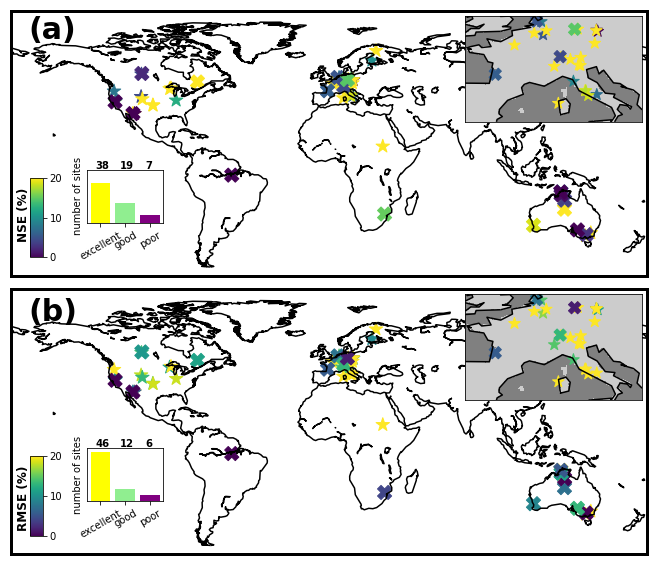

In [138]:

plt.figure(figsize=(20,10))

idx_sign = np.where(ttest[:,0]==1)[0]
idx_nosign = np.where(ttest[:,0]==0)[0]
print(idx_sign)
#-----------------------------------------------------------------------------------
ax1 = plt.subplot2grid((2, 1), (0, 0))

ax1.spines['left'].set_linewidth(3)
ax1.spines['bottom'].set_linewidth(3)
ax1.spines['right'].set_linewidth(3)
ax1.spines['top'].set_linewidth(3)

m = Basemap(projection='cyl',
            llcrnrlat=-60, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180,
            ax=ax1)  # mill projection
#m.bluemarble()
#m.etopo()
m.drawcoastlines(linewidth=1.5)
x, y = m(lon[idx_sign],lat[idx_sign])
sc = m.scatter(x,y, c=relative_improve_kge[idx_sign],  vmin=0, vmax=20, marker='*', s=200, )
x, y = m(lon[idx_nosign],lat[idx_nosign])
sc = m.scatter(x,y, c=relative_improve_kge[idx_nosign],  vmin=0, vmax=20, marker='X', s=200, )

axins = zoomed_inset_axes(ax1, 4, loc=1)

axins.set_xlim(-5,20)
axins.set_ylim(38,53)

submap = Basemap(projection='cyl',
                 llcrnrlat=38, urcrnrlat=53,
                 llcrnrlon=-5, urcrnrlon=20,
                 ax=axins)  # mill projection
#submap.etopo()

x,y = submap(lon,lat)
submap.drawcoastlines(linewidth=1.5)
x, y = submap(lon[idx_sign],lat[idx_sign])
sc = submap.scatter(x,y, c=relative_improve_kge[idx_sign],  vmin=0, vmax=20, marker='*', s=150, )
x, y = submap(lon[idx_nosign],lat[idx_nosign])
sc = submap.scatter(x,y, c=relative_improve_kge[idx_nosign],  vmin=0, vmax=20, marker='X', s=150,)
submap.drawlsmask(ocean_color='grey')


axin1 = ax1.inset_axes([0.12, 0.2, 0.12, 0.2])
axin1.bar(range(3), [38, 19, 7], color=['yellow', 'lightgreen','purple'])
axin1.set_xticks([0,1,2])
axin1.set_xticklabels(['excellent','good','poor'], rotation=30)
axin1.text(-0.2,  51, '38', fontweight='bold')
axin1.text(0.8,  51, '19', fontweight='bold')
axin1.text(1.8,  51, '7', fontweight='bold')
axin1.set_ylabel('number of sites')
axin1.set_yticks([])
axin1.set_ylim(0,50)

axin2 = ax1.inset_axes([0.03, 0.07, 0.02, 0.3])

# colorbar
cbar = plt.colorbar(sc, cax=axin2,)

# text colorbar
axin2.text(-20, 15, 'NSE (%)',color='black', fontsize=12, fontweight='bold', rotation=90)
axin2.text(-3, 55, '(a)',color='black', fontsize=30, fontweight='bold')
#axin2.text(80, 10, '>10%:'+str(len(np.where(relative_improve_kge>10)[0]))+' sites', fontsize=20, fontweight='bold')
#axin2.text(80, 6, '<10% and >0%:'+str(len(np.where((relative_improve_kge<10) & (relative_improve_kge>0))[0]))+' sites', fontsize=20, fontweight='bold')
#axin2.text(80, 2, '<0%:'+str(len(np.where(relative_improve_kge<0)[0]))+' sites', fontsize=20, fontweight='bold')


#-----------------------------------------------------------------------------------

#-------------------------------------------------------------------------------------------
ax1 = plt.subplot2grid((2, 1), (1,0))

ax1.spines['left'].set_linewidth(3)
ax1.spines['bottom'].set_linewidth(3)
ax1.spines['right'].set_linewidth(3)
ax1.spines['top'].set_linewidth(3)

m = Basemap(projection='cyl',
            llcrnrlat=-60, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180,
            ax=ax1)  # mill projection
m.drawcoastlines(linewidth=1.5)
x, y = m(lon[idx_sign],lat[idx_sign])
sc = m.scatter(x,y, c=relative_improve_rmse[idx_sign],  vmin=0, vmax=20, marker='*', s=200)
x, y = m(lon[idx_nosign],lat[idx_nosign])
sc = m.scatter(x,y, c=relative_improve_rmse[idx_nosign],  vmin=0, vmax=20, marker='X', s=200)

axins = zoomed_inset_axes(ax1, 4, loc=1)

axins.set_xlim(-5,20)
axins.set_ylim(38,53)

submap = Basemap(projection='cyl',
                 llcrnrlat=38, urcrnrlat=53,
                 llcrnrlon=-5, urcrnrlon=20,
                 ax=axins)  # mill projection

x,y = submap(lon,lat)
submap.drawcoastlines(linewidth=1.5)
x, y = submap(lon[idx_sign],lat[idx_sign])
sc = submap.scatter(x,y, c=relative_improve_rmse[idx_sign],  vmin=0, vmax=20, marker='*', s=150)
x, y = submap(lon[idx_nosign],lat[idx_nosign])
sc = submap.scatter(x,y, c=relative_improve_rmse[idx_nosign],  vmin=0, vmax=20, marker='X', s=150)
submap.drawlsmask(ocean_color='grey')



axin1 = ax1.inset_axes([0.12, 0.2, 0.12, 0.2])
axin1.bar(range(3), [46, 12, 6], color=['yellow', 'lightgreen','purple'])
axin1.set_xticks([0,1,2])
axin1.set_xticklabels(['excellent','good','poor'], rotation=30)
axin1.text(-0.2, 51, '46', fontweight='bold')
axin1.text(0.8, 51, '12', fontweight='bold')
axin1.text(1.8, 51, '6', fontweight='bold')
axin1.set_ylabel('number of sites')
axin1.set_yticks([])
axin1.set_ylim(0,50)

axin2 = ax1.inset_axes([0.03, 0.07, 0.02, 0.3])

# colorbar
cbar = plt.colorbar(sc, cax=axin2,)

# text colorbar
axin2.text(-20, 15, 'RMSE (%)',color='black', fontsize=12, fontweight='bold',rotation=90)
axin2.text(-3, 54, '(b)',color='black', fontsize=30, fontweight='bold')
#axin2.text(90, 10, '>10%:'+str(len(np.where(relative_improve_rmse>10)[0]))+' sites', fontsize=20, fontweight='bold')
#axin2.text(90, 6, '<10% and >0%:'+str(len(np.where((relative_improve_rmse<10) & (relative_improve_rmse>0))[0]))+' sites', fontsize=20, fontweight='bold')
#axin2.text(90, 2, '<0%:'+str(len(np.where(relative_improve_rmse<0)[0]))+' sites', fontsize=20, fontweight='bold')

#------------------------------------------------------------------------------------------

# -----------------------------------------------------------------------------------
plt.subplots_adjust(wspace=0.0, hspace=0.05)

plt.savefig('figure3.pdf')

CN-Cng
US-Ton
AU-Rig
BR-Sa3
AU-Stp
US-SRG


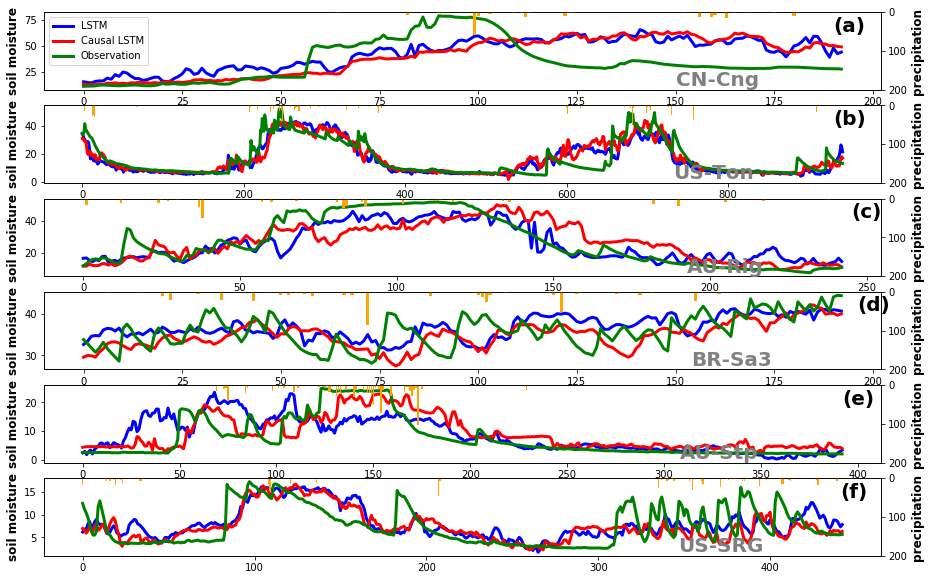

In [250]:
plt.figure(figsize=(15,10))
label = ['(a)','(b)','(c)','(d)','(e)','(f)']

for i, idx_ in enumerate([6,11,21,22,25,56]):
    
    plt.subplot(6,1,i+1)
    name = site_name_list[idx_]
    print(name)
    name_ = path_output+name+'_out.npy'
    output = np.load(name_)
    name_ = path_output+name+'_feature.npy'
    feature = np.load(name_)

    plt.plot(output[7:, 1], color='blue', linewidth=3)
    plt.plot(output[7:, 2], color='red', linewidth=3)
    plt.plot(output[:-7, -1], color='green', linewidth=3)
    plt.ylabel('soil moisture', fontsize=12, fontweight='bold')
    if i==4:
        plt.xlabel('Timestep', fontsize=20,fontweight='bold')
        
    if i==0:
        plt.legend(['LSTM', 'Causal LSTM', 'Observation'])

    ax1 = plt.twinx()
    plt.ylim(0,200)
    plt.ylabel('precipitation',fontsize=12, fontweight='bold')

    ax1.bar(x=np.arange(feature.shape[0]-7),height=feature[:-7,5], color='orange')
    plt.gca().invert_yaxis()
    if i==0:
        plt.text(150, 190, name,color='grey',fontweight='bold', fontsize=20)
        plt.text(190, 50, label[i],color='black',fontweight='bold', fontsize=20)
    else:
        plt.text(0.77*output.shape[0], 190, name,color='grey',fontweight='bold', fontsize=20)
        plt.text(0.98*output.shape[0], 50, label[i],color='black',fontweight='bold', fontsize=20)
        

plt.savefig('figure8.pdf')

# Figure 4

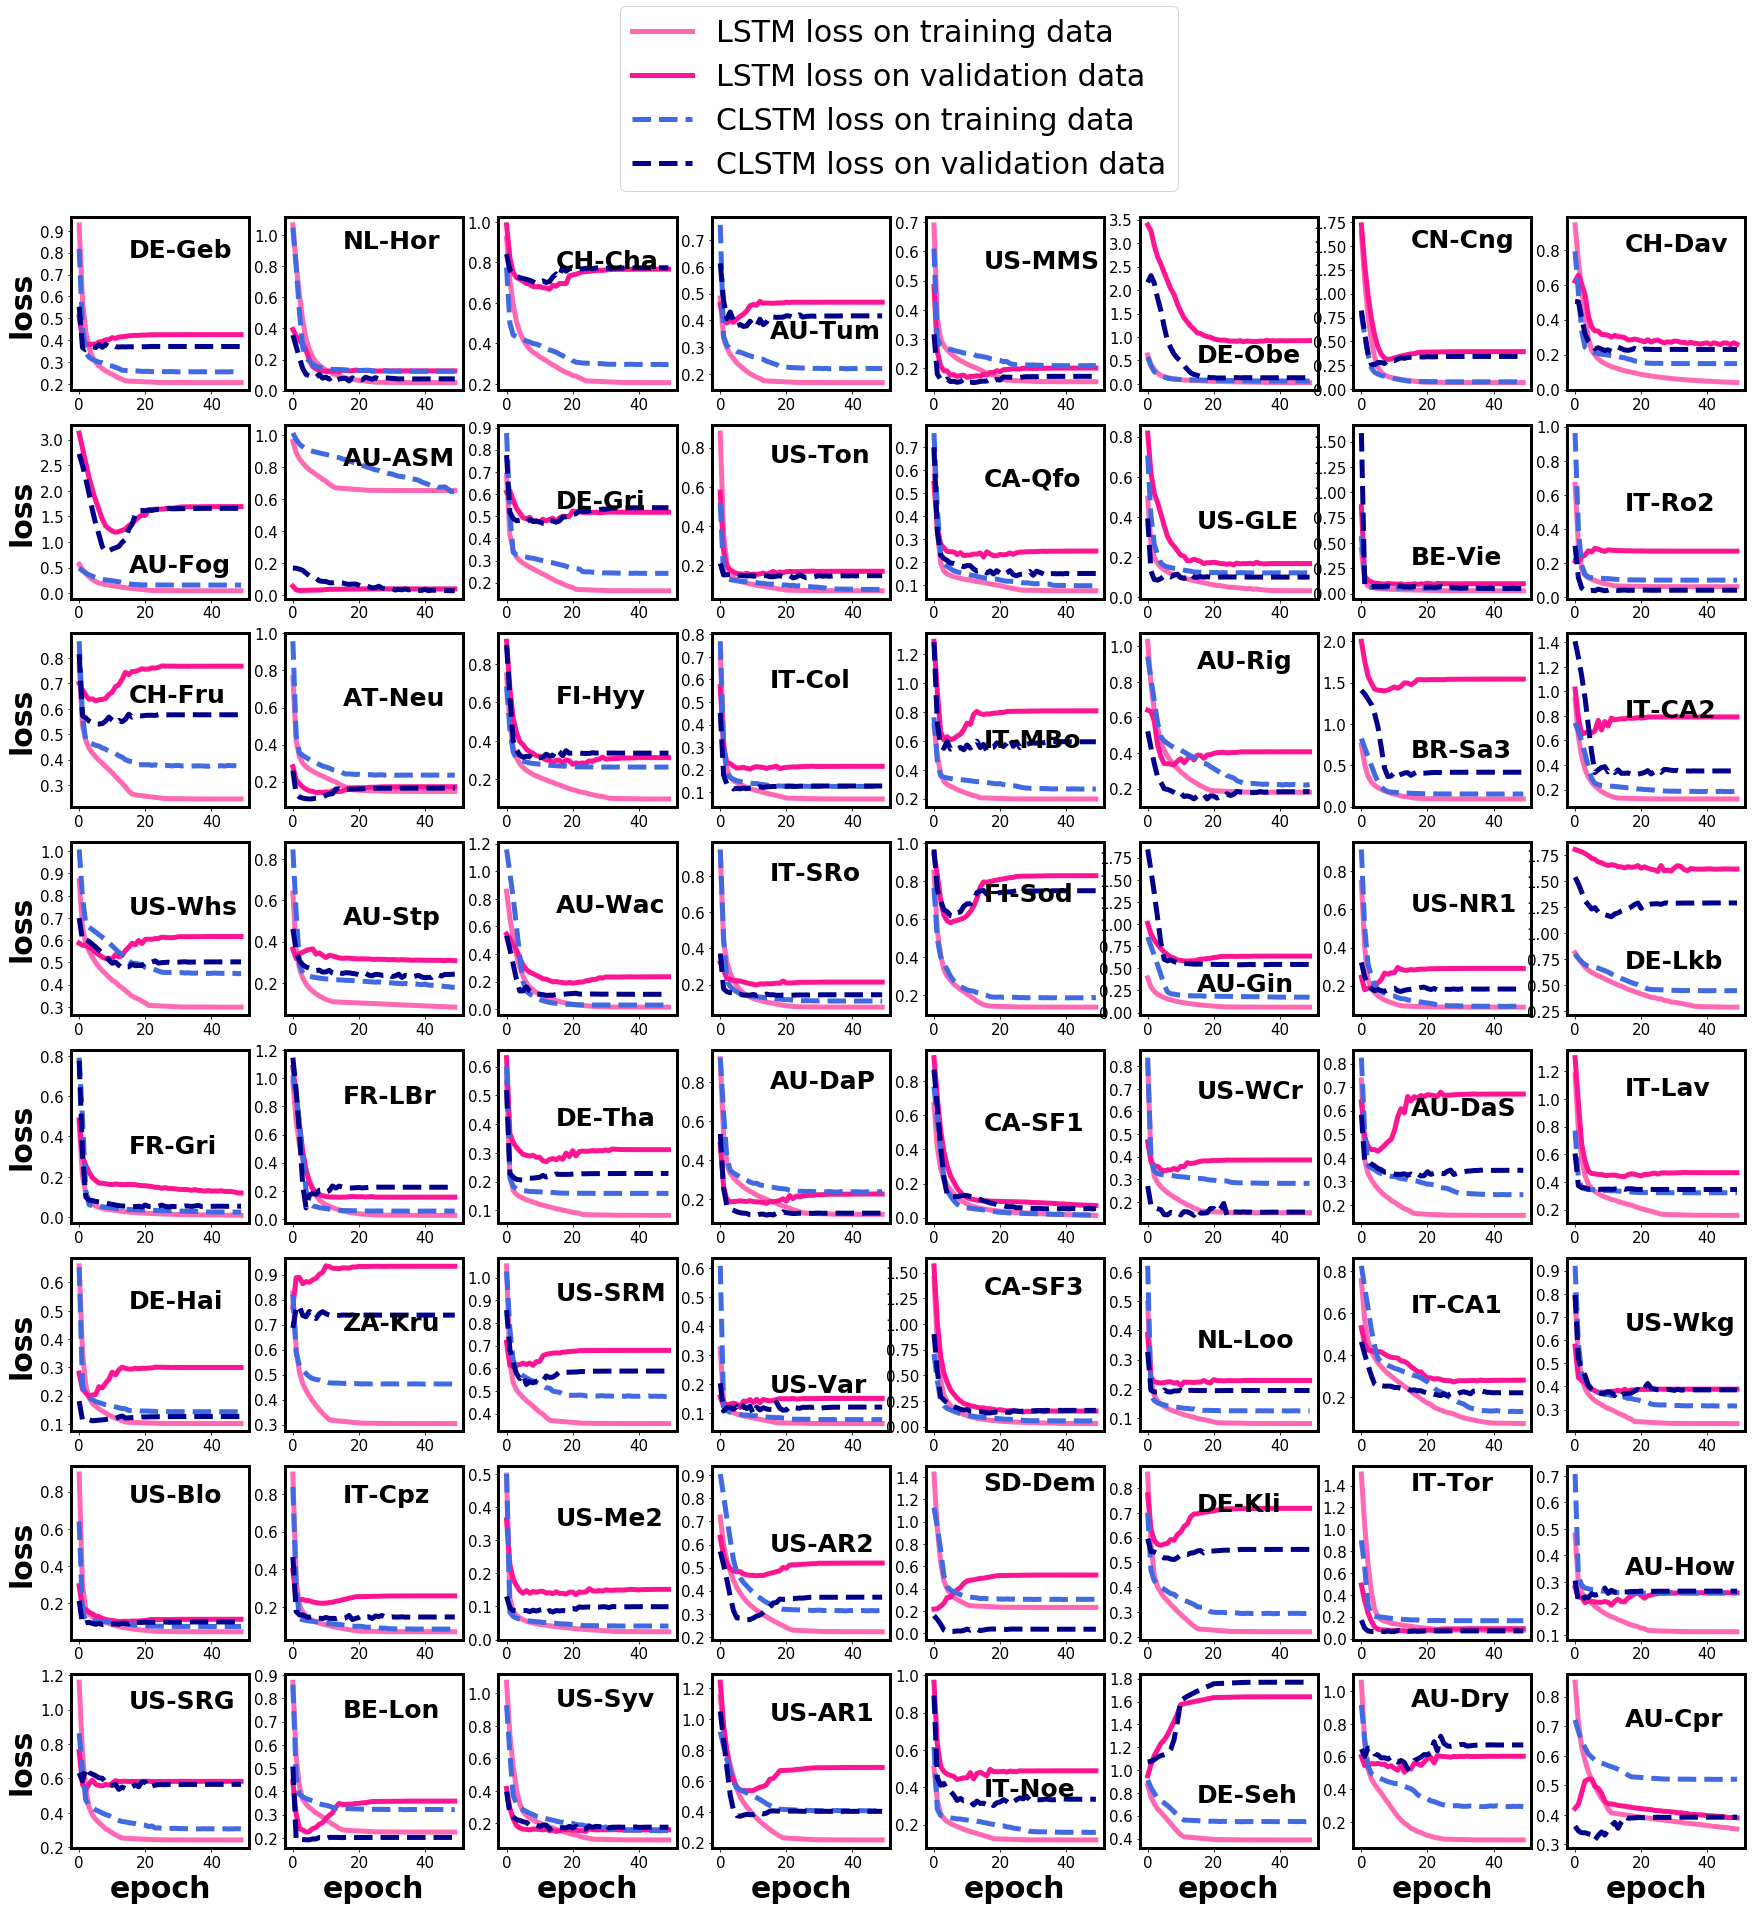

In [145]:
plt.figure(figsize=(30,30))

for i in range(len(site_name_list)):
    ax = plt.subplot(8, 8, i+1)
    
    ax.spines['top'].set_linewidth(3)
    ax.spines['right'].set_linewidth(3)
    ax.spines['left'].set_linewidth(3)
    ax.spines['bottom'].set_linewidth(3)

    lstm_loss = history[i,:,0]
    lstm_val_loss = history[i, :, 1]
    clstm_loss = history[i, :, 2]
    clstm_val_loss = history[i, :, 3]

    plt.plot(lstm_loss, linewidth=5, color='hotpink', linestyle='-')
    plt.plot(lstm_val_loss, linewidth=5, color='deeppink', linestyle='-')
    plt.plot(clstm_loss, linewidth=5, color='royalblue', linestyle='--')
    plt.plot(clstm_val_loss, linewidth=5, color='darkblue', linestyle='--')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    if i in np.arange(56,64):
        plt.xlabel('epoch', fontsize=30, fontweight='bold')
        
    if i in np.arange(0,64,8):
        plt.ylabel('loss', fontsize=30, fontweight='bold')
        
    if i==0:
        plt.legend(['LSTM loss on training data','LSTM loss on validation data','CLSTM loss on training data','CLSTM loss on validation data'], fontsize=30,loc='best',bbox_to_anchor=(5.5, 1.5, 0.8, 0.8))
        
    plt.text(15, np.nanmax(lstm_loss)-0.15, site_name_list[i], fontsize=25, fontweight='bold')
    
plt.savefig('figure4.pdf')

# Figure 5

In [35]:
def linear_(x,y):
    a, b = np.polyfit(x, y, deg=1)
    y_est = a * x + b
    y_err = x.std() * np.sqrt(1/len(x) + (x - x.mean())**2 / np.sum((x - x.mean())**2))
    
    return y_est, y_err, a, b

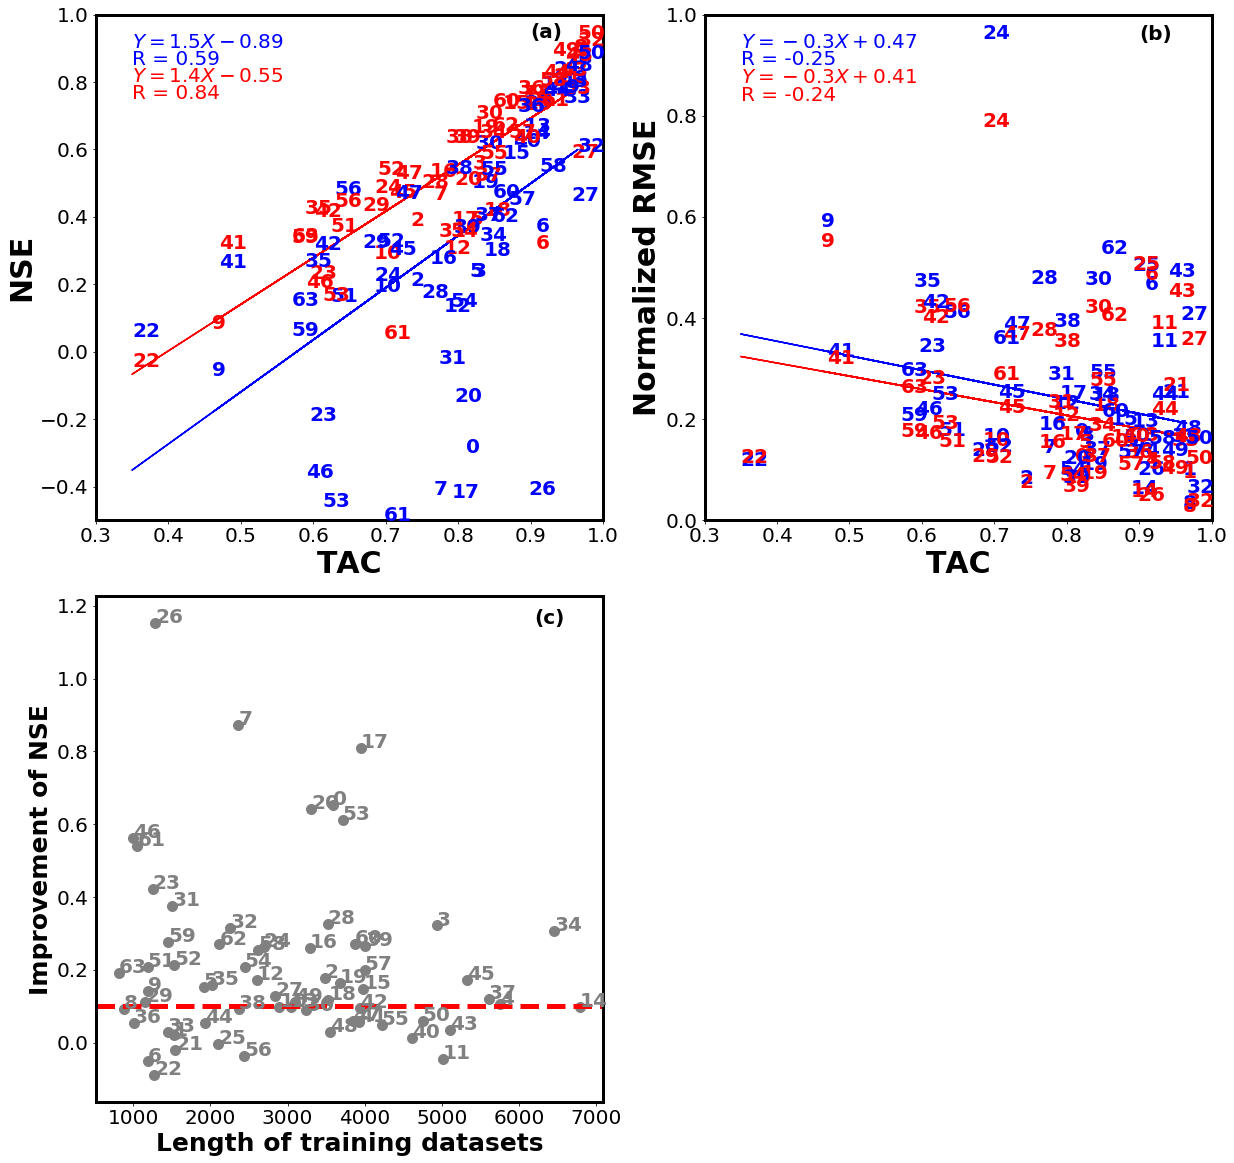

In [101]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))

#-----------------------------------------
y_est_lstm, y_err_lstm, a_lstm, b_lstm = linear_(tac, nse[:,1])
y_est_clstm, y_err_clstm, a_clstm, b_clstm = linear_(tac, nse[:,2])


ax1 = plt.subplot(2,2,1)


ax1.spines['left'].set_linewidth(3)
ax1.spines['bottom'].set_linewidth(3)
ax1.spines['right'].set_linewidth(3)
ax1.spines['top'].set_linewidth(3)

for i in range(len(tac)):
    plt.text(tac[i], nse[i,1], str(i),color='blue',fontsize=20,fontweight='bold')
    plt.text(tac[i], nse[i,2], str(i),color='red', fontsize=20,fontweight='bold')

#plt.scatter(tac, nse[:,1], c='lightblue')

plt.plot(tac, y_est_lstm, '-', color='blue')

#plt.scatter(tac, nse[:,2], c='lightgreen')
plt.plot(tac, y_est_clstm, '-', color='red')

plt.ylim(-0.5,1)
plt.xlim(0.3,1)

plt.xlabel('TAC', fontsize=30,fontweight='bold')
plt.ylabel('NSE', fontsize=30,fontweight='bold')
plt.text(0.35,0.9, '$Y = %.1fX %.2f$' % (a_lstm, b_lstm), color='blue',fontsize=20)
plt.text(0.35,0.85, 'R = '+ str(round(pearsonr(tac, nse[:,-2])[0],2)), color='blue',fontsize=20)

plt.text(0.35,0.8, '$Y = %.1fX %.2f$' % (a_clstm, b_clstm), color='red',fontsize=20)
plt.text(0.35,0.75, 'R = '+ str(round(pearsonr(tac, nse[:,-1])[0],2)), color='red',fontsize=20)
plt.text(0.9,0.93, '(a)',fontsize=20, fontweight='bold')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

#-----------------------------------------
y_est_lstm, y_err_lstm, a_lstm, b_lstm = linear_(tac, nrmse[:,1])
y_est_clstm, y_err_clstm, a_clstm, b_clstm = linear_(tac, nrmse[:,2])

ax1 = plt.subplot(2,2,2)


ax1.spines['left'].set_linewidth(3)
ax1.spines['bottom'].set_linewidth(3)
ax1.spines['right'].set_linewidth(3)
ax1.spines['top'].set_linewidth(3)

for i in range(len(tac)):
    plt.text(tac[i], nrmse[i,1], str(i),color='blue',fontsize=20,fontweight='bold')
    plt.text(tac[i], nrmse[i,2], str(i),color='red', fontsize=20,fontweight='bold')

#plt.scatter(tac, nse[:,1], c='lightblue')

plt.plot(tac, y_est_lstm, '-', color='blue')

#plt.scatter(tac, nse[:,2], c='lightgreen')
plt.plot(tac, y_est_clstm, '-', color='red')

plt.ylim(0,1)
plt.xlim(0.3,1)
plt.xlabel('TAC', fontsize=30,fontweight='bold')
plt.ylabel('Normalized RMSE', fontsize=30,fontweight='bold')
plt.text(0.35,0.935, '$Y = %.1fX + %.2f$' % (a_lstm, b_lstm), color='blue',fontsize=20)
plt.text(0.35,0.9, 'R = '+ str(round(pearsonr(tac, nrmse[:,-2])[0],2)), color='blue',fontsize=20)

plt.text(0.35,0.865, '$Y = %.1fX + %.2f$' % (a_clstm, b_clstm), color='red',fontsize=20)
plt.text(0.35,0.83, 'R = '+ str(round(pearsonr(tac, nrmse[:,-1])[0],2)), color='red',fontsize=20)
plt.text(0.9,0.95, '(b)',fontsize=20, fontweight='bold')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


ax2 = plt.subplot(223)
a = [5*i+np.random.randint(0,300) for i in length]

ax2.spines['left'].set_linewidth(3)
ax2.spines['bottom'].set_linewidth(3)
ax2.spines['right'].set_linewidth(3)
ax2.spines['top'].set_linewidth(3)

plt.scatter(x = a, y = relative_improve_nse/100, c='grey', s=100)

for i in np.arange(len(a)):
    ax2.text(a[i], relative_improve_nse[i]/100, str(i),color='grey',fontsize=20,fontweight='bold')

plt.axhline(y=0.1, linestyle='--',linewidth=5, color='red')
#plt.ylim(0,1)
plt.xlabel('Length of training datasets', fontsize=25,fontweight='bold')
plt.ylabel('Improvement of NSE', fontsize=25,fontweight='bold')
plt.text(6200,1.15, '(c)',fontsize=20, fontweight='bold')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.subplots_adjust(wspace=0.2, hspace=0.15)

plt.savefig('figure5.pdf')

# Figure 8

In [139]:
path_output = '/hard/lilu/2_CausalLSTM/clstmcases/1DD/output/'
path_loss = '/hard/lilu/2_CausalLSTM/clstmcases/1DD/loss/'
path_info = '/hard/lilu/2_CausalLSTM/clstmcases/1DD/info/'

l = glob.glob(path_output + '*' + '_out.npy', recursive=True)
N_sites = len(site_name_list)

# init
r = np.full((N_sites,3), np.nan)
nse = np.full((N_sites,3), np.nan)
rmse = np.full((N_sites,3), np.nan)
nrmse = np.full((N_sites,3), np.nan)
mape = np.full((N_sites,3), np.nan)
kge = np.full((N_sites,3), np.nan)
bias = np.full((N_sites,3), np.nan)
ttest = np.full((N_sites,2), 0)
length = np.full((N_sites,), np.nan)
tac = np.full((N_sites,), np.nan)


output_all_lstm_1d = np.full((1,),np.nan)
output_all_clstm_1d = np.full((1,),np.nan)
output_all_obs_1d = np.full((1,),np.nan)

for i,name_ in enumerate(site_name_list):
    
    output = np.load(path_output+name_+'_out.npy')
    length[i] = output.shape[0]
    
    output_all_lstm_1d = np.append(output_all_lstm_1d, output[:,1])
    output_all_clstm_1d = np.append(output_all_clstm_1d, output[:,2])
    output_all_obs_1d = np.append(output_all_obs_1d, output[:,-1])

In [140]:
import glob
path_output = '/hard/lilu/2_CausalLSTM/clstmcases/1DD/output/'
path_loss = '/hard/lilu/2_CausalLSTM/clstmcases/1DD/loss/'
path_info = '/hard/lilu/2_CausalLSTM/clstmcases/1DD/info/'

l = glob.glob(path_output + '*' + '_out.npy', recursive=True)
N_sites = len(site_name_list)

# init
r = np.full((N_sites,3), np.nan)
nse = np.full((N_sites,3), np.nan)
rmse = np.full((N_sites,3), np.nan)
nrmse = np.full((N_sites,3), np.nan)
mape = np.full((N_sites,3), np.nan)
kge = np.full((N_sites,3), np.nan)
bias = np.full((N_sites,3), np.nan)
ttest = np.full((N_sites,2), 0)
length = np.full((N_sites,), np.nan)
tac = np.full((N_sites,), np.nan)

for i,name_ in enumerate(site_name_list):
        
    output = np.load(path_output+name_+'_out.npy')
    length[i] = output.shape[0]
    
    # cal metrics
    r[i,0] = pearsonr(output[:,-1], output[:,0])[0]
    r[i,1] = pearsonr(output[:,-1], output[:,1])[0]
    r[i, 2] = pearsonr(output[:, -1], output[:, 2])[0]
    
    kge[i,0],beta[i,0], gamma[i,0]  = cal_kge(output[:,-1], output[:,0])
    kge[i,1],beta[i,1], gamma[i,1] = cal_kge(output[:,-1], output[:,1])
    kge[i, 2],beta[i,2], gamma[i,2] = cal_kge(output[:, -1], output[:, 2])    
    
    nse[i,0] = r2_score(output[:,-1], output[:,0])
    nse[i,1] = r2_score(output[:,-1], output[:,1])
    nse[i, 2] = r2_score(output[:, -1], output[:, 2])
    
    rmse[i,0] = np.sqrt(mean_squared_error(output[:,-1], output[:,0]))
    rmse[i,1] = np.sqrt(mean_squared_error(output[:,-1], output[:,1]))
    rmse[i, 2] = np.sqrt(mean_squared_error(output[:, -1], output[:, 2]))
    
    nrmse[i,0] = np.sqrt(mean_squared_error(output[:,-1], output[:,0]))/np.nanmean(output[:,-1])
    nrmse[i,1] = np.sqrt(mean_squared_error(output[:,-1], output[:,1]))/np.nanmean(output[:,-1])
    nrmse[i, 2] = np.sqrt(mean_squared_error(output[:, -1], output[:, 2]))/np.nanmean(output[:,-1])
    
    mape[i,0] = cal_mape(output[:,-1], output[:,0])
    mape[i,1] = cal_mape(output[:,-1], output[:,1])  
    mape[i, 2] = cal_mape(output[:, -1], output[:, 2])
    
    bias[i,0] = np.mean(output[:, -1])-np.mean(output[:, 0])
    bias[i,1] = np.mean(output[:, -1])-np.mean(output[:, 1])
    bias[i, 2] = np.mean(output[:, -1])-np.mean(output[:, 2])

    tac[i] = cal_autocorr(output[:, -1], t=7)[0, 1]

    t, p = stats.ttest_ind(np.abs(output[:,2]-output[:,-1]), np.abs(output[:,-1]-output[:,1]),alternative='less')
    if p<0.05:
        ttest[i,0] = 1
    
    t, p = stats.ttest_ind(np.abs(output[:,2]-output[:,-1]), np.abs(output[:,-1]-output[:,1]),alternative='greater')
    if p<0.05:
        ttest[i,1] = 1

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


In [141]:
output_dict = {
    'SITE_NAME': site_name_list, 
    'BIAS_LSTM': bias[:,1],
    'BIAS_CLSTM': bias[:,2],
    'KGE_LSTM': kge[:,1],
    'KGE_CLSTM': kge[:,2],
    'R_LSTM': r[:,1],
    'R_CLSTM': r[:,2],
    'BETA_LSTM': beta[:,1],
    'BETA_CLSTM': beta[:,2],
    'GAMMA_LSTM': gamma[:,1],
    'GAMMA_CLSTM': gamma[:,2],
    'R2_LSTM': nse[:,1],
    'R2_CLSTM': nse[:,2],
    'RMSE_LSTM': rmse[:,1],
    'RMSE_CLSTM': rmse[:,2],
    'MAPE_LSTM': mape[:,1],
    'MAPE_CLSTM': mape[:,2]
}

pd.set_option('precision', 2)

df_1DD = pd.DataFrame(data=output_dict)
df_1DD.to_csv('output_summary_1DD.csv')
df_1DD

,SITE_NAME,BIAS_LSTM,BIAS_CLSTM,KGE_LSTM,KGE_CLSTM,R_LSTM,R_CLSTM,BETA_LSTM,BETA_CLSTM,GAMMA_LSTM,GAMMA_CLSTM,R2_LSTM,R2_CLSTM,RMSE_LSTM,RMSE_CLSTM,MAPE_LSTM,MAPE_CLSTM
0,DE-Geb,-1.00,-0.44,0.83,0.90,0.84,0.91,1.05,1.02,1.02,1.02,0.53,0.78,1.91,1.30,7.92,5.08
1,NL-Hor,-1.46,-0.40,0.84,0.95,0.97,0.99,1.02,1.01,0.85,0.95,0.93,0.97,4.84,2.87,4.95,2.37
2,CH-Cha,0.84,0.27,0.90,0.88,0.90,0.91,0.98,1.00,0.98,0.92,0.77,0.82,2.15,1.92,2.59,2.37
3,AU-Tum,1.53,0.74,0.80,0.87,0.90,0.92,0.95,0.97,0.84,0.90,0.72,0.82,2.78,2.21,6.86,5.02
4,US-MMS,-0.37,-0.27,0.95,0.96,0.95,0.97,1.01,1.01,0.98,0.98,0.90,0.93,2.31,1.94,5.47,4.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,US-AR1,0.61,-0.10,0.74,0.87,0.76,0.91,0.97,1.01,0.91,0.92,0.54,0.82,2.68,1.67,10.35,5.43
60,IT-Noe,1.11,0.13,0.77,0.92,0.89,0.95,0.96,1.00,0.80,0.94,0.76,0.90,3.79,2.49,7.56,3.91
61,DE-Seh,-4.64,-2.55,0.21,0.51,0.65,0.82,1.20,1.11,0.32,0.56,-0.14,0.48,7.07,4.79,33.66,22.74
62,AU-Dry,0.58,0.43,0.82,0.93,0.89,0.95,0.93,0.95,0.88,1.00,0.78,0.90,2.54,1.73,17.25,14.16


In [142]:
path_output = '/hard/lilu/2_CausalLSTM/clstmcases/15DD/output/'
path_loss = '/hard/lilu/2_CausalLSTM/clstmcases/15DD/loss/'
path_info = '/hard/lilu/2_CausalLSTM/clstmcases/15DD/info/'

l = glob.glob(path_output + '*' + '_out.npy', recursive=True)
N_sites = len(site_name_list)

# init
r = np.full((N_sites,3), np.nan)
nse = np.full((N_sites,3), np.nan)
rmse = np.full((N_sites,3), np.nan)
nrmse = np.full((N_sites,3), np.nan)
mape = np.full((N_sites,3), np.nan)
kge = np.full((N_sites,3), np.nan)
bias = np.full((N_sites,3), np.nan)
ttest = np.full((N_sites,2), 0)
length = np.full((N_sites,), np.nan)
tac = np.full((N_sites,), np.nan)

for i,name_ in enumerate(site_name_list):
        
    output = np.load(path_output+name_+'_out.npy')
    length[i] = output.shape[0]
    
    # cal metrics
    r[i,0] = pearsonr(output[:,-1], output[:,0])[0]
    r[i,1] = pearsonr(output[:,-1], output[:,1])[0]
    r[i, 2] = pearsonr(output[:, -1], output[:, 2])[0]
    
    kge[i,0],beta[i,0], gamma[i,0]  = cal_kge(output[:,-1], output[:,0])
    kge[i,1],beta[i,1], gamma[i,1] = cal_kge(output[:,-1], output[:,1])
    kge[i, 2],beta[i,2], gamma[i,2] = cal_kge(output[:, -1], output[:, 2])    
    
    nse[i,0] = r2_score(output[:,-1], output[:,0])
    nse[i,1] = r2_score(output[:,-1], output[:,1])
    nse[i, 2] = r2_score(output[:, -1], output[:, 2])
    
    rmse[i,0] = np.sqrt(mean_squared_error(output[:,-1], output[:,0]))
    rmse[i,1] = np.sqrt(mean_squared_error(output[:,-1], output[:,1]))
    rmse[i, 2] = np.sqrt(mean_squared_error(output[:, -1], output[:, 2]))

    
    nrmse[i,0] = np.sqrt(mean_squared_error(output[:,-1], output[:,0]))/np.nanmean(output[:,-1])
    nrmse[i,1] = np.sqrt(mean_squared_error(output[:,-1], output[:,1]))/np.nanmean(output[:,-1])
    nrmse[i, 2] = np.sqrt(mean_squared_error(output[:, -1], output[:, 2]))/np.nanmean(output[:,-1])
    
    mape[i,0] = cal_mape(output[:,-1], output[:,0])
    mape[i,1] = cal_mape(output[:,-1], output[:,1])  
    mape[i, 2] = cal_mape(output[:, -1], output[:, 2])
    
    bias[i,0] = np.mean(output[:, -1])-np.mean(output[:, 0])
    bias[i,1] = np.mean(output[:, -1])-np.mean(output[:, 1])
    bias[i, 2] = np.mean(output[:, -1])-np.mean(output[:, 2])

    tac[i] = cal_autocorr(output[:, -1], t=7)[0, 1]

    t, p = stats.ttest_ind(np.abs(output[:,2]-output[:,-1]), np.abs(output[:,-1]-output[:,1]),alternative='less')
    if p<0.05:
        ttest[i,0] = 1
    
    t, p = stats.ttest_ind(np.abs(output[:,2]-output[:,-1]), np.abs(output[:,-1]-output[:,1]),alternative='greater')
    if p<0.05:
        ttest[i,1] = 1

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


In [143]:
output_dict = {
    'SITE_NAME': site_name_list, 
    'BIAS_LSTM': bias[:,1],
    'BIAS_CLSTM': bias[:,2],
    'KGE_LSTM': kge[:,1],
    'KGE_CLSTM': kge[:,2],
    'R_LSTM': r[:,1],
    'R_CLSTM': r[:,2],
    'BETA_LSTM': beta[:,1],
    'BETA_CLSTM': beta[:,2],
    'GAMMA_LSTM': gamma[:,1],
    'GAMMA_CLSTM': gamma[:,2],
    'R2_LSTM': nse[:,1],
    'R2_CLSTM': nse[:,2],
    'RMSE_LSTM': rmse[:,1],
    'RMSE_CLSTM': rmse[:,2],
    'MAPE_LSTM': mape[:,1],
    'MAPE_CLSTM': mape[:,2]
}

pd.set_option('precision', 2)

df_15DD = pd.DataFrame(data=output_dict)
df_15DD.to_csv('output_summary_15DD.csv')
df_15DD

,SITE_NAME,BIAS_LSTM,BIAS_CLSTM,KGE_LSTM,KGE_CLSTM,R_LSTM,R_CLSTM,BETA_LSTM,BETA_CLSTM,GAMMA_LSTM,GAMMA_CLSTM,R2_LSTM,R2_CLSTM,RMSE_LSTM,RMSE_CLSTM,MAPE_LSTM,MAPE_CLSTM
0,DE-Geb,-2.15,-2.06,4.24e-01,0.66,0.44,0.69,1.11,1.11,0.91,0.91,-0.76,-0.21,3.58,2.97,16.24,13.58
1,NL-Hor,-3.35,-2.57,7.15e-01,0.73,0.87,0.89,1.04,1.03,0.75,0.76,0.72,0.76,9.55,8.82,9.49,8.92
2,CH-Cha,1.89,2.04,4.79e-01,0.43,0.48,0.43,0.97,0.96,1.02,1.08,-0.20,-0.39,4.87,5.24,6.37,7.15
3,AU-Tum,3.12,1.61,5.53e-01,0.71,0.62,0.72,0.89,0.94,0.79,0.94,0.01,0.39,5.14,4.03,13.56,10.62
4,US-MMS,-1.37,-1.65,5.86e-01,0.61,0.72,0.64,1.04,1.05,0.70,0.85,0.48,0.30,5.34,6.20,14.07,15.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,US-AR1,2.32,-0.32,1.37e-01,0.16,0.15,0.18,0.88,1.02,0.98,0.82,-1.02,-0.41,4.49,3.76,17.27,15.95
60,IT-Noe,1.43,1.17,6.22e-01,0.75,0.68,0.77,0.95,0.96,0.80,0.90,0.43,0.56,5.90,5.15,14.76,12.04
61,DE-Seh,-6.92,-8.66,-8.12e-03,-0.73,0.53,-0.41,1.30,1.38,0.16,0.06,-1.00,-1.93,9.01,10.91,44.96,54.45
62,AU-Dry,0.27,0.91,5.54e-01,0.76,0.61,0.80,0.97,0.88,0.79,1.06,0.35,0.60,4.46,3.50,38.54,52.39


/root/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


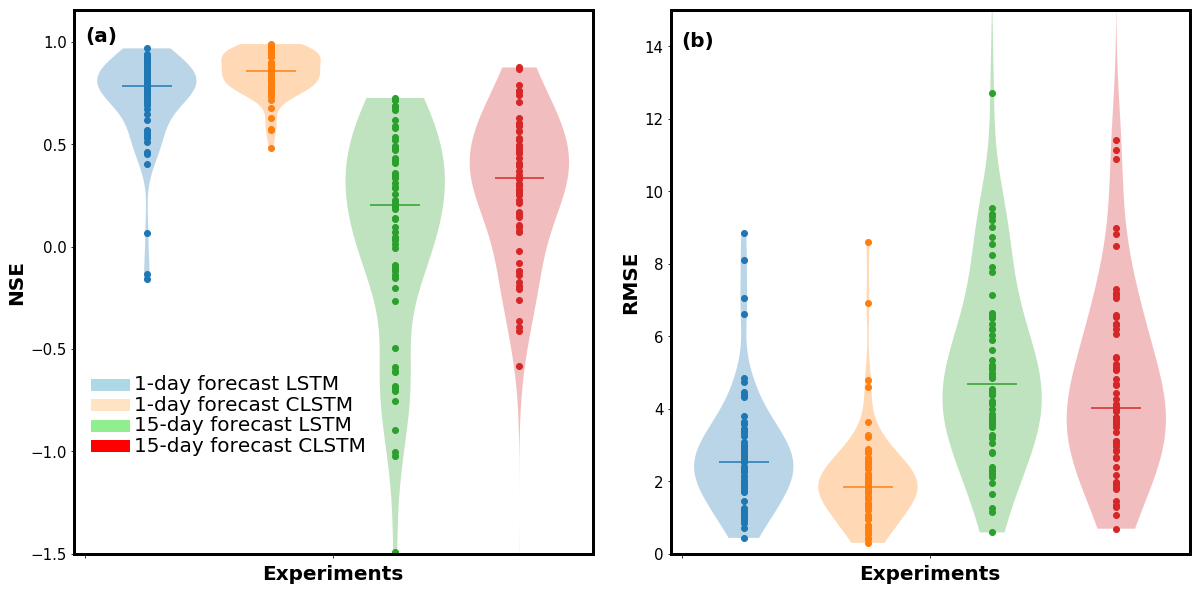

In [144]:
fig = plt.figure(figsize=(20,10))

#------------------------------------------------------------------------------------------------
ax1 = plt.subplot(1,2,1)

ax1.violinplot(df_1DD['R2_LSTM'].values, positions=[0.25],widths=0.4,showmedians=True, showextrema=False)
ax1.violinplot(df_1DD['R2_CLSTM'].values, positions=[0.75],widths=0.4,showmedians=True, showextrema=False)
ax1.violinplot(df_15DD['R2_LSTM'].values, positions=[1.25],widths=0.4,showmedians=True, showextrema=False)
ax1.violinplot(df_15DD['R2_CLSTM'].values, positions=[1.75],widths=0.4,showmedians=True, showextrema=False)

ax1.scatter(0.25*np.ones((64,)), df_1DD['R2_LSTM'].values, marker='o',)
ax1.scatter(0.75*np.ones((64,)), df_1DD['R2_CLSTM'].values, marker='o',)
ax1.scatter(1.25*np.ones((64,)), df_15DD['R2_LSTM'].values, marker='o',)
ax1.scatter(1.75*np.ones((64,)), df_15DD['R2_CLSTM'].values, marker='o',)


ax1.set_ylabel('NSE', fontsize=20, fontweight='bold')
ax1.set_xlabel('Experiments', fontsize=20, fontweight='bold')
ax1.text(0.,1,'(a)',fontsize=20, fontweight='bold')
plt.yticks(fontsize=15)
plt.ylim(ymin=-1.5)

#------------------------------------------------------------------------------------------------

#------------------------------------------------------------------------------------------------
ax2 = plt.subplot(1, 2, 2)

ax2.violinplot(df_1DD['RMSE_LSTM'].values, positions=[0.25],widths=0.4,showmedians=True, showextrema=False)
ax2.violinplot(df_1DD['RMSE_CLSTM'].values, positions=[0.75],widths=0.4,showmedians=True, showextrema=False)
ax2.violinplot(df_15DD['RMSE_LSTM'].values, positions=[1.25],widths=0.4,showmedians=True, showextrema=False)
ax2.violinplot(df_15DD['RMSE_CLSTM'].values, positions=[1.75],widths=0.4,showmedians=True, showextrema=False)

ax2.scatter(0.25*np.ones((64,)), df_1DD['RMSE_LSTM'].values, marker='o',)
ax2.scatter(0.75*np.ones((64,)), df_1DD['RMSE_CLSTM'].values, marker='o',)
ax2.scatter(1.25*np.ones((64,)), df_15DD['RMSE_LSTM'].values, marker='o',)
ax2.scatter(1.75*np.ones((64,)), df_15DD['RMSE_CLSTM'].values, marker='o',)

ax2.set_ylabel('RMSE', fontsize=20,fontweight='bold')
ax2.set_xlabel('Experiments', fontsize=20, fontweight='bold')
ax2.text(0,14,'(b)',fontsize=20, fontweight='bold')
plt.yticks(fontsize=15)
plt.ylim(0,15)
#------------------------------------------------------------------------------------------------
for ax in [ax1, ax2]:
    ax.set_xticks([0,1])
    ax.set_xticklabels(['',''])

    ax.spines['top'].set_linewidth(3)
    ax.spines['right'].set_linewidth(3)
    ax.spines['left'].set_linewidth(3)
    ax.spines['bottom'].set_linewidth(3)

ax1.plot([0.05,0.16], [-0.975,-0.975], color='red', linewidth=12)
ax1.plot([0.05, 0.16], [-0.875, -0.875], color='lightgreen', linewidth=12)
ax1.plot([0.05, 0.16], [-0.775, -0.775], color='bisque', linewidth=12)
ax1.plot([0.05, 0.16], [-0.675, -0.675], color='lightblue', linewidth=12)
ax1.text(0.2, -0.7, '1-day forecast LSTM',fontsize=20)
ax1.text(0.2, -0.8, '1-day forecast CLSTM', fontsize=20)
ax1.text(0.2, -0.9, '15-day forecast LSTM',fontsize=20)
ax1.text(0.2, -1, '15-day forecast CLSTM',fontsize=20)

plt.subplots_adjust(wspace=0.15, hspace=0.05)

plt.savefig('figure8.png')

In [145]:
path_output = '/hard/lilu/2_CausalLSTM/clstmcases/15DD/output/'
path_loss = '/hard/lilu/2_CausalLSTM/clstmcases/15DD/loss/'
path_info = '/hard/lilu/2_CausalLSTM/clstmcases/15DD/info/'

l = glob.glob(path_output + '*' + '_out.npy', recursive=True)
N_sites = len(site_name_list)

# init
r = np.full((N_sites,3), np.nan)
nse = np.full((N_sites,3), np.nan)
rmse = np.full((N_sites,3), np.nan)
nrmse = np.full((N_sites,3), np.nan)
mape = np.full((N_sites,3), np.nan)
kge = np.full((N_sites,3), np.nan)
bias = np.full((N_sites,3), np.nan)
ttest = np.full((N_sites,2), 0)
length = np.full((N_sites,), np.nan)
tac = np.full((N_sites,), np.nan)


output_all_lstm_15d = np.full((1,),np.nan)
output_all_clstm_15d = np.full((1,),np.nan)
output_all_obs_15d = np.full((1,),np.nan)

for i,name_ in enumerate(site_name_list):
    
    output = np.load(path_output+name_+'_out.npy')
    length[i] = output.shape[0]
    
    output_all_lstm_15d = np.append(output_all_lstm_15d, output[:,1])
    output_all_clstm_15d = np.append(output_all_clstm_15d, output[:,2])
    output_all_obs_15d = np.append(output_all_obs_15d, output[:,-1])

(0, 100)

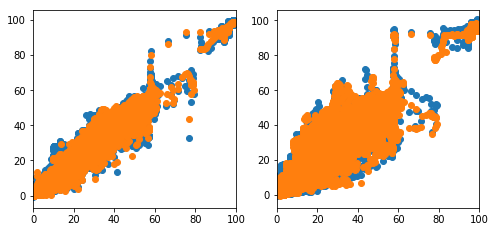

In [146]:
plt.figure(figsize=(8,8))

plt.subplot(2,2,1)
plt.scatter(output_all_obs_1d,output_all_lstm_1d)
plt.scatter(output_all_obs_1d,output_all_clstm_1d)
plt.xlim(0,100)
plt.xlim(0,100)

plt.subplot(2,2,2)
plt.scatter(output_all_obs_15d,output_all_lstm_15d)
plt.scatter(output_all_obs_15d,output_all_clstm_15d)
plt.xlim(0,100)
plt.xlim(0,100)

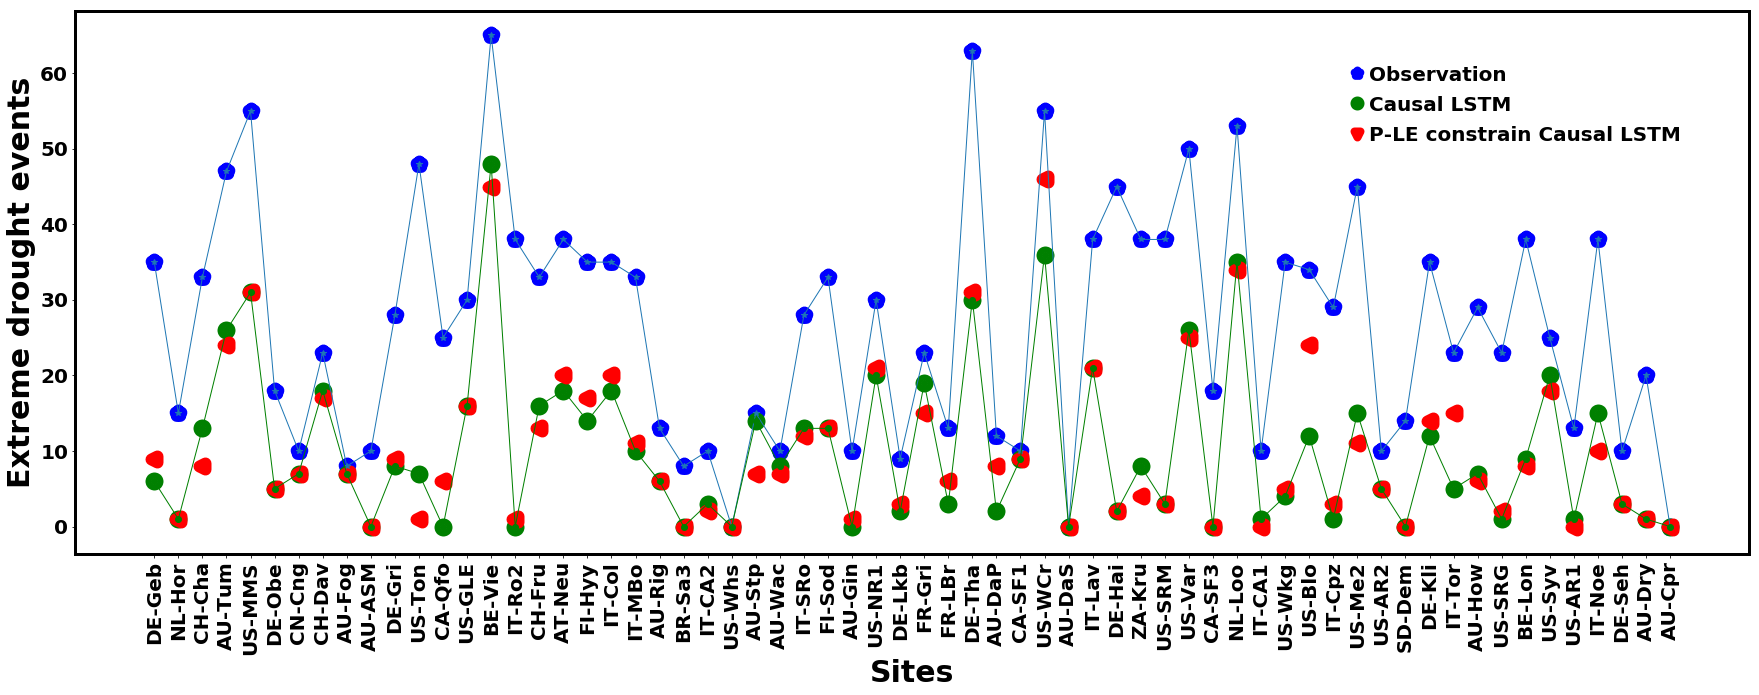

In [98]:
c_clstm_p = np.zeros((len(site_name_list),))
c_clstm_lh = np.zeros((len(site_name_list),))
c_clstm_p_lh = np.zeros((len(site_name_list),))
c_clstm = np.zeros((len(site_name_list),))
c_lstm = np.zeros((len(site_name_list),))
c_ob = np.zeros((len(site_name_list),))

for k, name_ in enumerate(site_name_list):
    output = np.load( '/hard/lilu/2_CausalLSTM/clstmcases/7DD_threshold-0.5/output/'+name_+'_out.npy')
    feature = np.load( '/hard/lilu/2_CausalLSTM/clstmcases/7DD_threshold-0.5/output/'+name_+'_feature.npy')

    output_p = np.load( '/hard/lilu/2_CausalLSTM/pclstmcases/p_constrain/output/'+name_+'_out.npy')
    output_lh = np.load( '/hard/lilu/2_CausalLSTM/pclstmcases/lh_constrain/output/'+name_+'_out.npy')
    output_p_lh = np.load( '/hard/lilu/2_CausalLSTM/pclstmcases/p_lh_constrain/output/'+name_+'_out.npy')
    
    SWDI = SWDIcount(output[:,-1])   
    SWDI_clstm = SWDIcount(output[:,2])   
    SWDI_p = SWDIcount(output_p[:,2])   
    SWDI_lh = SWDIcount(output_lh[:,2])   
    SWDI_p_lh = SWDIcount(output_p_lh[:,2])   

    count_clstm_p = 0
    count_clstm_lh = 0
    count_clstm_p_lh = 0
    count_clstm = 0
    count_lstm = 0
    count = 0

    """
    for i in range(SWDI.shape[0]):
        if (SWDI[i]<-5) and (SWDI[i]>-10):
            if (SWDI_clstm[i]<-5) and (SWDI_clstm[i]>-10):
                count_clstm += 1
            if (SWDI_p[i]<-5) and (SWDI_p[i]>-10):
                count_clstm_p += 1
            if (SWDI_lh[i]<-5) and (SWDI_lh[i]>-10):
                count_clstm_lh += 1
            if (SWDI_p_lh[i]<-5) and (SWDI_p_lh[i]>-10):
                count_clstm_p_lh += 1
            count += 1    
    """
    
    for i in range(SWDI.shape[0]):
        if (SWDI[i]<-10):
            if (SWDI_clstm[i]<-10):
                count_clstm += 1
            if (SWDI_p[i]<-10):
                count_clstm_p += 1
            if (SWDI_lh[i]<-10):
                count_clstm_lh += 1
            if (SWDI_p_lh[i]<-10):
                count_clstm_p_lh += 1
            count += 1    
            
    c_clstm_p[k] = count_clstm_p
    c_clstm_lh[k] = count_clstm_lh
    c_clstm_p_lh[k] = count_clstm_p_lh
    c_clstm[k] = count_clstm
    c_lstm[k] = count_lstm
    c_ob[k] = count
                
plt.figure(figsize=(30,10))
ax = plt.subplot(111)
ax.spines['top'].set_linewidth(3)
ax.spines['right'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
ax.spines['bottom'].set_linewidth(3)
plt.scatter(np.arange(len(site_name_list)),c_ob, marker='*', linewidth=12,c='blue')
plt.plot(np.arange(len(site_name_list)),c_ob, marker='*', linewidth=1)

#plt.scatter(np.arange(len(site_name_list)),c_lstm, marker='^', linewidth=3)
#plt.plot(np.arange(len(site_name_list)),c_lstm, marker='^', linewidth=3)

plt.scatter(np.arange(len(site_name_list)),c_clstm, marker='o', linewidth=12, c='green')
plt.plot(np.arange(len(site_name_list)),c_clstm, marker='o', linewidth=1, c='green')

#plt.scatter(np.arange(len(site_name_list)),c_clstm_p, marker='v', linewidth=8, c='red')
#plt.plot(np.arange(len(site_name_list)),c_clstm_p, marker='v', linewidth=1, c='red')

#plt.scatter(np.arange(len(site_name_list)),c_clstm_lh, marker='>', linewidth=8, c='orange')
plt.scatter(np.arange(len(site_name_list)),c_clstm_p_lh, marker='<', linewidth=12, c='red')
plt.xlabel('Sites',fontweight='bold',fontsize=30)
plt.ylabel('Extreme drought events',fontweight='bold',fontsize=30)
#plt.legend(['ob','clstm','clstm_p','clstm_lh','clstm_p_lh'])

ax.set_xticks(np.arange(len(site_name_list)))
ax.set_xticklabels(site_name_list, rotation=90)

plt.scatter(50, 60, marker='*',c='blue',linewidth=8)
plt.text(50.5, 59, 'Observation', fontweight='bold',fontsize=20)
plt.scatter(50, 56, marker='o',c='green',linewidth=8)
plt.text(50.5, 55, 'Causal LSTM', fontweight='bold',fontsize=20)
#plt.scatter(55, 52, marker='v',c='red',linewidth=8)
#plt.text(55.5, 51, 'P constrain Causal LSTM', fontweight='bold',fontsize=10)
#plt.scatter(55, 48, marker='>',c='orange',linewidth=8)
#plt.text(55.5, 47, 'LE constrain Causal LSTM', fontweight='bold',fontsize=10)
plt.scatter(50, 52, marker='v',c='red',linewidth=8)
plt.text(50.5, 51, 'P-LE constrain Causal LSTM', fontweight='bold',fontsize=20)

plt.xticks(fontsize=20, fontweight='bold')
plt.yticks(fontsize=20, fontweight='bold')
#plt.ylim(0,20)
        
plt.savefig('figure11.pdf')